In [1]:
import pandas as pd
import numpy as np
from google_sheet_api import GoogleSheetAPI
import matplotlib.pyplot as plt

In [2]:
data_mx3 = pd.read_csv('yolobench_mx3_fps_latency.csv')
data_mx3 = data_mx3.rename(columns={"FPS": "FPS_MX3"})
data_mx3 = data_mx3.rename(columns={"InOutLatency": "latency_MX3"})
data_mx3 = data_mx3.set_index('Model')
data_mx3

,FPS_MX3,latency_MX3
Model,,
yolo3d1w25_160,1366.25,2.95
yolo3d1w25_192,950.78,3.48
yolo3d1w25_224,699.13,4.28
yolo3d1w25_256,535.85,4.91
yolo3d1w25_288,423.54,5.94
...,...,...
yolo8s_352,520.03,5.70
yolo8s_384,374.44,6.44
yolo8s_416,349.28,7.26


In [3]:
gs = GoogleSheetAPI('GPU-Auto-Bench1')

<bound method Spreadsheet.worksheets of <Spreadsheet 'GPU-Auto-Bench1' id:1IietP-8Y7HORErw4ijG6qe2rlmVyxBTKVelGJD80aDw>>


# Batch Size = 1 comparison

In [4]:
# batch_size = 1 analysis
data_b1 = data_mx3.copy()
gpus = {'A2000': '528616448', '4060': '1360528374', 'AGX_CUDA': '13202610', 'AGX_TensorRT': '1697549124'}
for gpu_name, worksheet_id in gpus.items():
    gs.open_worksheet(worksheet_id)
    data_gpu = gs.get_dataframe('A1:F3556', includes_header=True)
    data_gpu_b1 = data_gpu[data_gpu['Batch Size'] == '1']
    data_gpu_b1 = data_gpu_b1.set_index('Model')
    data_gpu_b1 = data_gpu_b1.astype({'FPS': 'float'})
    column_name = 'FPS_' + gpu_name
    data_gpu_b1 = data_gpu_b1.rename(columns={'FPS': column_name})
    data_b1 = data_b1.join(data_gpu_b1[column_name])


In [5]:
data_b1

,FPS_MX3,latency_MX3,FPS_A2000,FPS_4060,FPS_AGX_CUDA,FPS_AGX_TensorRT
Model,,,,,,
yolo3d1w25_160,1366.25,2.95,490.0,654.0,80.0,325.0
yolo3d1w25_192,950.78,3.48,465.0,599.0,77.0,315.0
yolo3d1w25_224,699.13,4.28,441.0,538.0,75.0,291.0
yolo3d1w25_256,535.85,4.91,427.0,510.0,71.0,282.0
yolo3d1w25_288,423.54,5.94,390.0,459.0,70.0,260.0
...,...,...,...,...,...,...
yolo8s_352,520.03,5.70,291.0,396.0,80.0,193.0
yolo8s_384,374.44,6.44,269.0,377.0,79.0,171.0
yolo8s_416,349.28,7.26,243.0,330.0,76.0,164.0


In [6]:
def compare_to_mx3(data, field_name, png_name=None):
    xmax = 1.05 * max(data.FPS_MX3)
    plt.plot(data[field_name], data.FPS_MX3,'.')
    plt.xlabel(field_name)
    plt.ylabel('FPS_MX3')
    plt.plot([0, xmax], [0, xmax], 'k--')
    plt.xlim([0, xmax])
    plt.ylim([0, xmax])
    plt.title('Yolobench FPS comparison')
    plt.grid()
    if png_name:
        plt.savefig(png_name)
    plt.show()

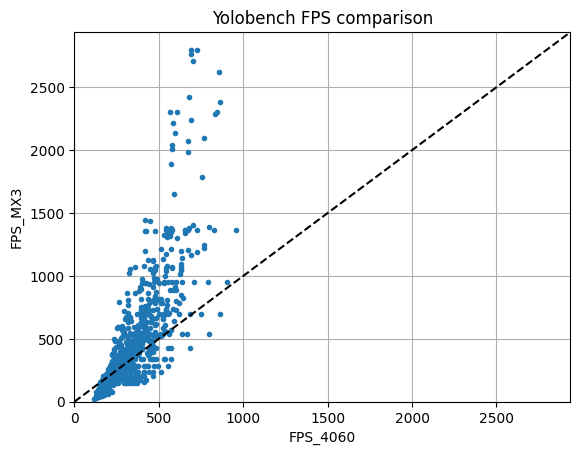

In [7]:
compare_to_mx3(data_b1, 'FPS_4060', png_name='yolobench_BS1_MX3_FPS_4060.png')

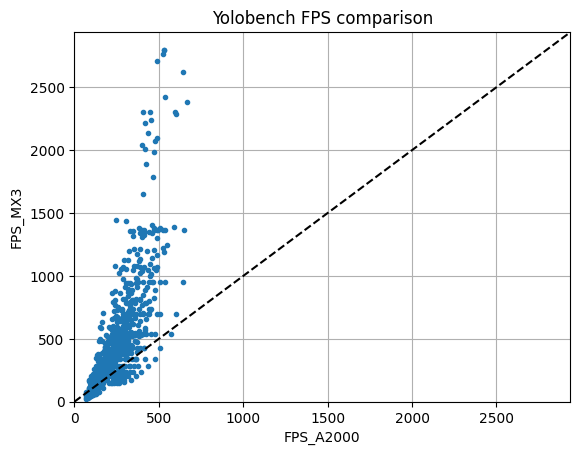

In [8]:
compare_to_mx3(data_b1, 'FPS_A2000', png_name='yolobench_BS1_MX3_FPS_A2000.png')

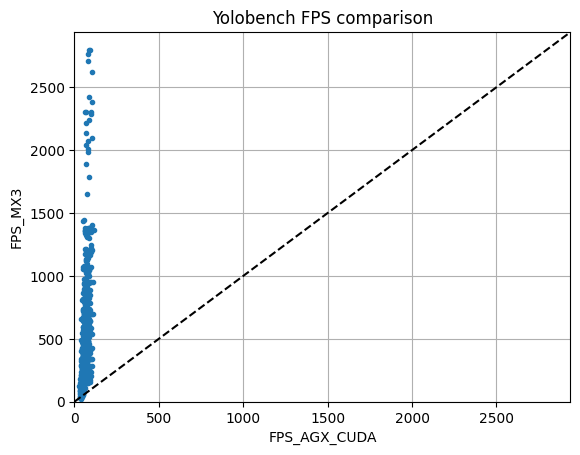

In [9]:
compare_to_mx3(data_b1, 'FPS_AGX_CUDA', png_name='yolobench_BS1_MX3_FPS_AGX_CUDA.png')

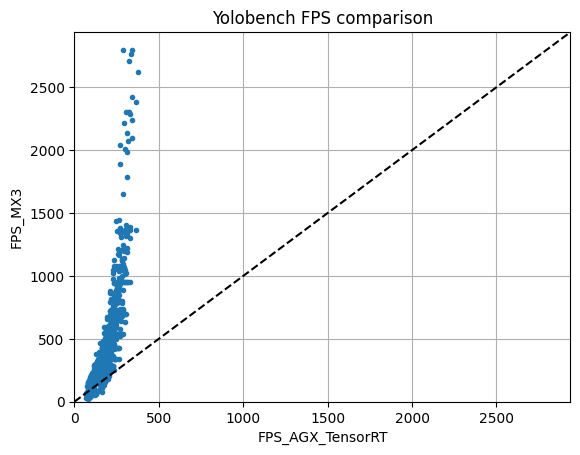

In [10]:
compare_to_mx3(data_b1, 'FPS_AGX_TensorRT', png_name='yolobench_BS1_MX3_FPS_AGX_TensorRT.png')

# Similar Latency Comparison

In [11]:

data_mx3 = pd.read_csv('yolobench_mx3_fps_latency.csv')
data_mx3 = data_mx3.rename(columns={"FPS": "FPS_MX3"})
data_mx3 = data_mx3.rename(columns={"InOutLatency": "latency_MX3"})
data_mx3 = data_mx3.set_index('Model')
data_mx3 = data_mx3.sort_values(by='latency_MX3')

gs = GoogleSheetAPI('GPU-Auto-Bench1')
gpus = {'A2000': '528616448', '4060': '1360528374'}
for gpu_name, worksheet_id in gpus.items():
    gs.open_worksheet(worksheet_id)
    data_gpu = gs.get_dataframe('A1:E3556', includes_header=True)
    data_gpu = data_gpu.set_index('Model')
    data_gpu = data_gpu.drop(columns='Resolution')
    data_gpu = data_gpu.astype({'Latency(ms)': 'float'})
    data_gpu = data_gpu.astype({'FPS': 'float'})
    data_gpu = data_gpu.rename(columns={'Batch Size': f'Batch Size {gpu_name}'})
    data_gpu = data_gpu.rename(columns={'FPS': f'FPS_{gpu_name}'})
    data_gpu = data_gpu.rename(columns={'Latency(ms)': f'latency_{gpu_name}'})
    data_gpu = data_gpu.sort_values(by=f'latency_{gpu_name}')
    data_mx3 = pd.merge_asof(data_mx3, data_gpu, by='Model', left_on='latency_MX3', right_on=f'latency_{gpu_name}', direction='nearest')

<bound method Spreadsheet.worksheets of <Spreadsheet 'GPU-Auto-Bench1' id:1IietP-8Y7HORErw4ijG6qe2rlmVyxBTKVelGJD80aDw>>


In [12]:
data_mx3 = data_mx3.sort_values(by='Model')
data_mx3

,Model,FPS_MX3,latency_MX3,Batch Size A2000,FPS_A2000,latency_A2000,Batch Size 4060,FPS_4060,latency_4060
37,yolo3d1w25_160,1366.25,2.95,2,877.0,3.4,2,1028.0,2.9
64,yolo3d1w25_192,950.78,3.48,2,797.0,3.8,2,937.0,3.2
100,yolo3d1w25_224,699.13,4.28,2,738.0,4.1,2,911.0,3.3
136,yolo3d1w25_256,535.85,4.91,2,638.0,4.7,4,1219.0,5.7
198,yolo3d1w25_288,423.54,5.94,2,575.0,5.2,4,997.0,7.0
...,...,...,...,...,...,...,...,...,...
187,yolo8s_352,520.03,5.70,1,291.0,3.4,2,521.0,5.8
230,yolo8s_384,374.44,6.44,2,334.0,9.0,2,496.0,6.0
268,yolo8s_416,349.28,7.26,1,243.0,4.1,2,423.0,7.1
307,yolo8s_448,287.39,7.96,1,221.0,4.5,2,365.0,8.2


In [13]:
data_mx3['Batch Size A2000'].value_counts()

Batch Size A2000
2    560
1     95
4     50
6      6
Name: count, dtype: int64

In [14]:
data_mx3['Batch Size 4060'].value_counts()

Batch Size 4060
2    398
4    252
6     38
8     23
Name: count, dtype: int64

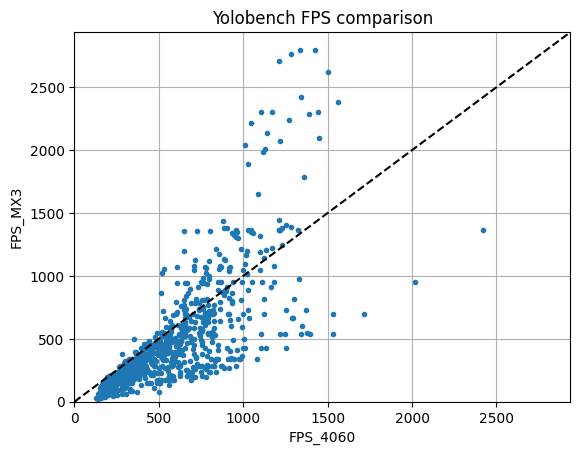

In [15]:
compare_to_mx3(data_mx3, 'FPS_4060', png_name='yolobench_SL_MX3_FPS_4060.png')

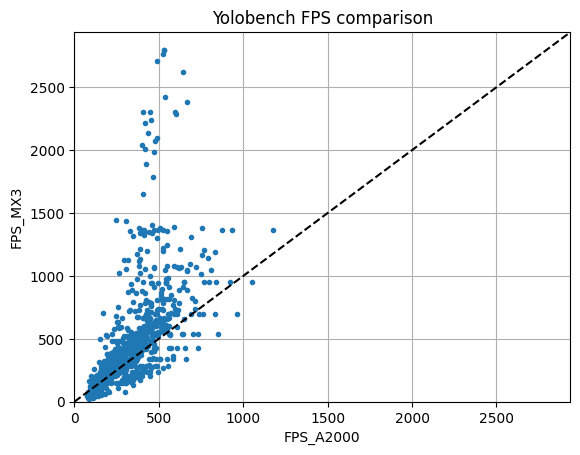

In [16]:
compare_to_mx3(data_mx3, 'FPS_A2000', png_name='yolobench_SL_MX3_FPS_A2000.png')

In [17]:
#data_mx3.to_csv('yolobench_similar_latency.csv')